# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

## IMPORT

In [2]:
'''IMPORTING LIBRARIES'''

'''Import packages &libraries for all the rest of the code'''
import sys
import subprocess
if 'google.colab' in sys.modules:
  #subprocess.call("pip install -U opencv-python".split())
  subprocess.call("pip install -U progress".split())
  #subprocess.call("pip install tensorflow==2.0.*".split())
  #subprocess.call("pip install keras==2.3.1".split())
#TensorFlow 2.0 and Keras 2.3.1 frameworks   

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps

from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, save_model, load_model
import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 40 )

print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))

Tensor Flow 2.8.2
Keras 2.8.0


## DRIVE 

In [3]:
'''MOUNTH THE DRIVE FOLDER TO INTERACT WITH IMAGES AND TO SAVE/LOAD MODELS AND PARAMETERS'''

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/MyDrive/'
path = path_drive+'ProgettoDL/'
path_IMAGES = '/content/drive/MyDrive/CALCIO_CROP_BASE/'

Mounted at /content/drive


## Parametri Immagini 

In [4]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''

'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir('/content/drive/MyDrive/ProgettoDL/') 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 6  

'''some useful parameters and variables'''
parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

'''series of production & quality classes of the wood rifle butt'''
#classi = ['1','2','3','4']    
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 

cod_componente = [ 2,  4,  8, 10,  6,  9,  3, 11, 12, 13, 14, 15,  7] #forse non serve

'''size of the images & their paths (location) '''
immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

'''CSV loading (reading annotations/attributes/informations)'''
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

'''check if we're working with coloured or gray images'''
if 'gray' in tipo:
  colormode = "grayscale"
  print('analisi in scala di grigi')
else:
  colormode = "rgb"

## SPLIT DATA

In [5]:
'''CUSTOM SPLIT DATA INTO TRAIN/TEST/VALIDATION SETS'''
"""
NOTE
- VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE PESI IN MODO AUTOMATICO (STUDIA ALTERNATIVA)
- UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE,
(perchè lo stesso ID deve stare in stesso set anche se i lati del calcio del fucile possono avere qualità differente)
"""

'''split method'''
def split_data(dataframe_result, val_size, test_size, random_state):
  #n_ immagini per ciascuna classe di qualità
  classes_count = dataframe_result.groupby(['class']).size() 
  #data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
  #label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
  #val_size = 0.2 scelta nel codice
  #test_size = 0.2 scelta nel codice
  #random_state = 3 (parametro impostato nel codice)

  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)   #conto quanti ID univoci esistono nel dataset e li raccolgo tutti in vettore

  '''randomizing the order of the IDs, (to change the sequence change the random_state)'''
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))

               
  '''define finals sub-sets of data'''
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  '''define variables to count elements inside the sub-sets'''
  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0

  """
  alternatives of programming methods

  #test_size = int(test_size*len(id_perm))   
  ##print('Test Size : {}'.format(test_size))                            
  #val_size = int(val_size*len(id_perm))   
  ##print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  #test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  #val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  #train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
  """  


  '''performing cycles to divide the images into the 3 sub-sets'''
  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < int((classes_count[0]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < int((classes_count[1]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < int((classes_count[2]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < int((classes_count[3]/100)*60) :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < int((classes_count[4]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < int((classes_count[5]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < int((classes_count[6]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < int((classes_count[7]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < int((classes_count[8]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < int((classes_count[9]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*60) and conta0 < int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*60) and conta1 < int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*60) and conta2 < int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*60) and conta3 < int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*60) and conta4 < int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*60) and conta5 < int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*60) and conta6 < int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*60) and conta7 < int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*60) and conta8 < int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*60) and conta9 < int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val

'''
#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'
#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
 
  for i in test_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_test=x_test.append(row_1, ignore_index=True) 
    x_test=x_test.append(row_2, ignore_index=True)
  
  for i in val_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_val=x_val.append(row_1, ignore_index=True) 
    x_val=x_val.append(row_2, ignore_index=True)
  
  for i in train_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    row_1=result_ID.iloc[0]
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_train=x_train.append(row_1, ignore_index=True) 
    x_train=x_train.append(row_2, ignore_index=True)
'''

"\n#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'\n#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte\n \n  for i in test_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n    row_1=result_ID.iloc[0]\n    row_2=result_ID.iloc[1]\n    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))\n    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))\n    x_test=x_test.append(row_1, ignore_index=True) \n    x_test=x_test.append(row_2, ignore_index=True)\n  \n  for i in val_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n   

## DATA GENERATION 

In [6]:
'''CUSTOM DATA GENERATOR CLASS AND DATA AUGMENTATION METHODS'''
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

class CustomDataGen(tf.keras.utils.Sequence):
    '''constructor method'''
    def __init__(self, df, X_col, y_col,
                 
                 batch_size,
                 input_size = (495, 1050), #era 270 x 470
                 shuffle = True,
                 class_weights = None):
      
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.class_weights = class_weights
        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        self.classi_augmented = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}  #to count wich quality classes are augmented during the training on the fly
        #self.classi_augmented = {0: 0, 1: 0, 2: 0, 3: 0}  #to count wich quality classes are augmented during the training on the fly

        self.n_SERIE_CALCIO = df[y_col['GEOMETRIA']].nunique()
        self.serie_augmented = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}  #to count wich series are augmented during the training on the fly (NOT USED IN THE CODE)

        '''augmentation method'''
        self.augmentor = ImageDataGenerator(
            print("[INFO] performing 'on the fly' data augmentation"),   #verification of effective execution
            horizontal_flip = True,   #we augment images by flipping them
            brightness_range = [0.2,0.5], #change brightness
            preprocessing_function = None,
            fill_mode = 'constant',
            #rescale=1. / 255,
            cval = 0.0
        )

        '''if weighted when called 'model.fit' the model will perform the training with augmentation, in other case without augmentation'''
        if self.class_weights is not None:
          self.df2 = df.copy()
          self.class_weights = class_weights.copy()
    
    #def on_epoch_end(self):
     #   if self.shuffle:
      #      self.df.sample(frac=1).reset_index(drop=True)
    
    '''load the images and manipulate it'''
    def __get_input(self, path, target_size):
      try:
        if os.path.exists('/content/drive/MyDrive/CALCIO_NOPRE/'+path) != False: 
          try: 
            image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CALCIO_NOPRE/'+path, color_mode="rgb" , target_size=(target_size[0],target_size[1]), interpolation="nearest")
          except Exception:
            print('Errore Image NOT LOAD')
      except Exception:
        print('\n{} not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      image_arr = tf.keras.applications.vgg16.preprocess_input(image_arr)               #PREPROCESSING: serve per normalizzare, quindi la rete viene addestrata per certi valori (senza preprocessing non riuscirebbe a generalizzare?)
      image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

      return image_arr/255.     #perchè di base è tra [0 255] invece deve tornare un valore tra 0 e 1 
      #return image_arr
    
    '''quality classes transformed to categorical in order to correctly use the loss=categorical_crossentropy'''
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    '''series of production transformed to categorical in order to correctly use the loss=categorical_crossentropy'''
    def __get_output2(self, label, num_series):
        return tf.keras.utils.to_categorical(label, num_classes=num_series)
    
    '''given a SINGLE batch, the method call other methods to pre-process the images and the informations'''
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['PATH_IMG']]  #column where to get the informations
        CLASSE_batch = batches[self.y_col['CLASSE']]
        SERIE_batch = batches[self.y_col['GEOMETRIA']]
        
        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
        y_batch_ = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        z_batch_ = np.asarray([self.__get_output2(z, self.n_SERIE_CALCIO) for z in SERIE_batch])
        y_batch = [y_batch_, z_batch_]  #architecture with multioutput (2 distinct outputs: series, quality_classes), so we need to connect them into a vector 
        
        return X_batch, y_batch
    
    '''principal method who calls iteratively all the other methods'''
    def __getitem__(self, index):      
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]  #calculate the batch indeces
        
        X, y = self.__get_data(batches) #getting the effective data pre-processed

        '''performing data augmentation'''
        if self.class_weights is not None:
          sample_weighttt = self.__get_samples_weights_V2(y[0])
          X_gen = self.augmentor.flow(X, batch_size=self.batch_size, shuffle=False, sample_weight=sample_weighttt)#, save_to_dir="/content/drive/MyDrive/Augmentation")
    
         #old alternative of calling the augmentation method
         #X_gen=self.augmentor.flow_from_dataframe(dataframe=batches, directory="/content/drive/MyDrive/CALCIO_CROP", x_col="filename", y_col="class", batch_size=self.batch_size, 
          #                                        seed=42,shuffle=False,class_mode=None, sample_weight=sample_weighttt, target_size=self.input_size, classes=['1','2-','2','2+','3-','3','3+','4-','4','4+'])
          
          return next(X_gen), y      # - next ritorna iterativamente ogni elemento creato con l'augmentation - https://www.w3schools.com/python/ref_func_next.asp
        else:              
          return X, y   #X è input (immagini), y sono gli output (classi,serie)

    '''return length of the batch'''
    def __len__(self):
        return int(self.n) // self.batch_size

    '''calculate sample weights from the elements of each precise batch to perform correctly the augmentation'''
    def __get_samples_weights_V2(self, y):
          labels = []
          for x_row in y: 
            #print(' y : {}'.format(y[0]))
            #print(x_row[0].shape)
            class_array = np.where(x_row == 1)      #values are in one-hot encoding, so the elements are rapresented by vectors of dimension [1,10], so the position of the value 1 rapresent the quality class
            classe_ = class_array[0]
            labels.append(classe_[0])
          
          labels_batch = np.array(labels)          
          
          class_weight_present_batch = { your_key: self.class_weights[your_key] for your_key in np.unique(labels_batch)}
          
          weights = compute_sample_weight(class_weight_present_batch,  labels_batch)
          #weights = compute_sample_weight(class_weight="balanced", y=labels_batch) #potrebbe generare errori, quando alcuni classi non sono presenti nel batch 

          for your_key in np.unique(labels_batch):
            self.classi_augmented[your_key] +=1
        
          weights = np.array(weights)
          return weights


## PREPROCESSING IMAGES & DATA FRAME CREATION

In [7]:
'''verify that same IDs are in the same sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")

'''method for univoque sets'''
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    Returns: leakage (bool): True if there is leakage, otherwise False
    """
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
    return leakage

------------------------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pandas.compat._optional import import_optional_dependency


os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()


'''reading inforamtions from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')

#--------TORNA QUI ---------
os.chdir(path_IMAGES)

i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists(path_IMAGES+filename) == False:
      
      print('File Non Esiste !!!')
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")
train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)

#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [9]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
result_class = result.groupby(['class']).size()
print(result_class)
result_series = result.groupby(['series']).size()
print(result_series)

print('SOMMA IMG : {}'.format(result_class[0]+result_class[1]+result_class[2]+result_class[3]+result_class[4]+result_class[5]+result_class[6]+result_class[7]+result_class[8]+result_class[9]))

Verifica Classi Qualità per ogni Serie
class
0.0    165
1.0    148
2.0    212
3.0    177
4.0    179
5.0    307
6.0    343
7.0    208
8.0    275
9.0    106
dtype: int64
series
0     120
1     224
2     200
3     226
4     430
5     120
6     168
7     218
8      28
9      76
10     54
11     74
12    182
dtype: int64
SOMMA IMG : 2120


##PARTI UTILI SE DOVREMO FARE LOSS CUSTOMIZZATE.        ----      ORA È INUTILE

In [10]:
"""
'''PARTE CHE FORSE POTRA SERVIRE SE DOVREMO FARE UN LOSS CUSTOMIZZATA'''
print(result2['series'].nunique())
#stampo il numero di calci per ciascuna serie
print("serie 2")
print(len(result2[result2['series'] == 0]))
print("serie 4")
print(len(result2[result2['series'] == 1]))
print("serie 8")
print(len(result2[result2['series'] == 2]))
print("serie 10")
print(len(result2[result2['series'] == 3]))
print("serie 6")
print(len(result2[result2['series'] == 4]))
print("serie 9")
print(len(result2[result2['series'] == 5]))
print("serie 3")
print(len(result2[result2['series'] == 6]))
print("serie 11")
print(len(result2[result2['series'] == 7]))
print("serie 12")
print(len(result2[result2['series'] == 8]))
print("serie 13")
print(len(result2[result2['series'] == 9]))
print("serie 14")
print(len(result2[result2['series'] == 10]))
print("serie 15")
print(len(result2[result2['series'] == 11]))
print("serie 7")
print(len(result2[result2['series'] == 12]))

appoggio = result2.groupby(["series", "class"]).size().reset_index(name="frequence")
print("appoggio frequenza valori")
print(appoggio)

#creo matrici per i pesi che serviranno per la loss
matrix = [[0, 0, 0, 0, 0, 24, 85, 9, 2, 0], [0, 32, 149, 26, 14, 3, 0, 0, 0, 0], [1, 0, 0, 0, 11, 176, 12, 0, 0, 0], [151, 19, 18, 4, 7, 10, 13, 2, 0, 2], [0, 0, 0, 0, 0, 1, 19, 99, 252, 59], [0, 0, 1, 0, 2, 33, 70, 12, 2, 0], [0, 0, 0, 11, 141, 16, 0, 0, 0, 0], [3, 79, 27, 105, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 8, 2, 18], [10, 18, 17, 31, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 3, 35, 1, 14], [0, 0, 0, 0, 0, 0, 7, 43, 11, 13], [0, 0, 0, 0, 0, 43, 134, 0, 5, 0] ]
print(matrix)
#print(matrix[0][6]) #prova di indici

max_top = [max(x) for x in matrix]
print(max_top)
#print(max_top[12])

#come scritto nel paper, pesi più alti per classi di qualità più rare in certe series
weights = np.zeros((13,10))
print(weights)
i=0
j=0
for i in range(13):
  max_val = max_top[i]
  for j in range(10):
    if (matrix[i][j] == 0):
      weights[i][j] = 0
    else:
      weights[i][j] = max_val/matrix[i][j]
print(weights)

#EVENTUALMENTE PROVARE ALTERNATIVA CALCOLANDO LE WEIGHTS PER CIASCUNA SERIE DISTINTAMENTE (compute_class_weights usata sopra)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
"""

'\n\'\'\'PARTE CHE FORSE POTRA SERVIRE SE DOVREMO FARE UN LOSS CUSTOMIZZATA\'\'\'\nprint(result2[\'series\'].nunique())\n#stampo il numero di calci per ciascuna serie\nprint("serie 2")\nprint(len(result2[result2[\'series\'] == 0]))\nprint("serie 4")\nprint(len(result2[result2[\'series\'] == 1]))\nprint("serie 8")\nprint(len(result2[result2[\'series\'] == 2]))\nprint("serie 10")\nprint(len(result2[result2[\'series\'] == 3]))\nprint("serie 6")\nprint(len(result2[result2[\'series\'] == 4]))\nprint("serie 9")\nprint(len(result2[result2[\'series\'] == 5]))\nprint("serie 3")\nprint(len(result2[result2[\'series\'] == 6]))\nprint("serie 11")\nprint(len(result2[result2[\'series\'] == 7]))\nprint("serie 12")\nprint(len(result2[result2[\'series\'] == 8]))\nprint("serie 13")\nprint(len(result2[result2[\'series\'] == 9]))\nprint("serie 14")\nprint(len(result2[result2[\'series\'] == 10]))\nprint("serie 15")\nprint(len(result2[result2[\'series\'] == 11]))\nprint("serie 7")\nprint(len(result2[result2[

##Weighted Categorical Cross-Entrophy

In [11]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred):
        #print('stop')
        
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## NETWORK 

Model: "quality_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 270, 470, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 270, 470, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 270, 470, 64  36928       ['block1_conv1[0][0]']           
                                )                                                

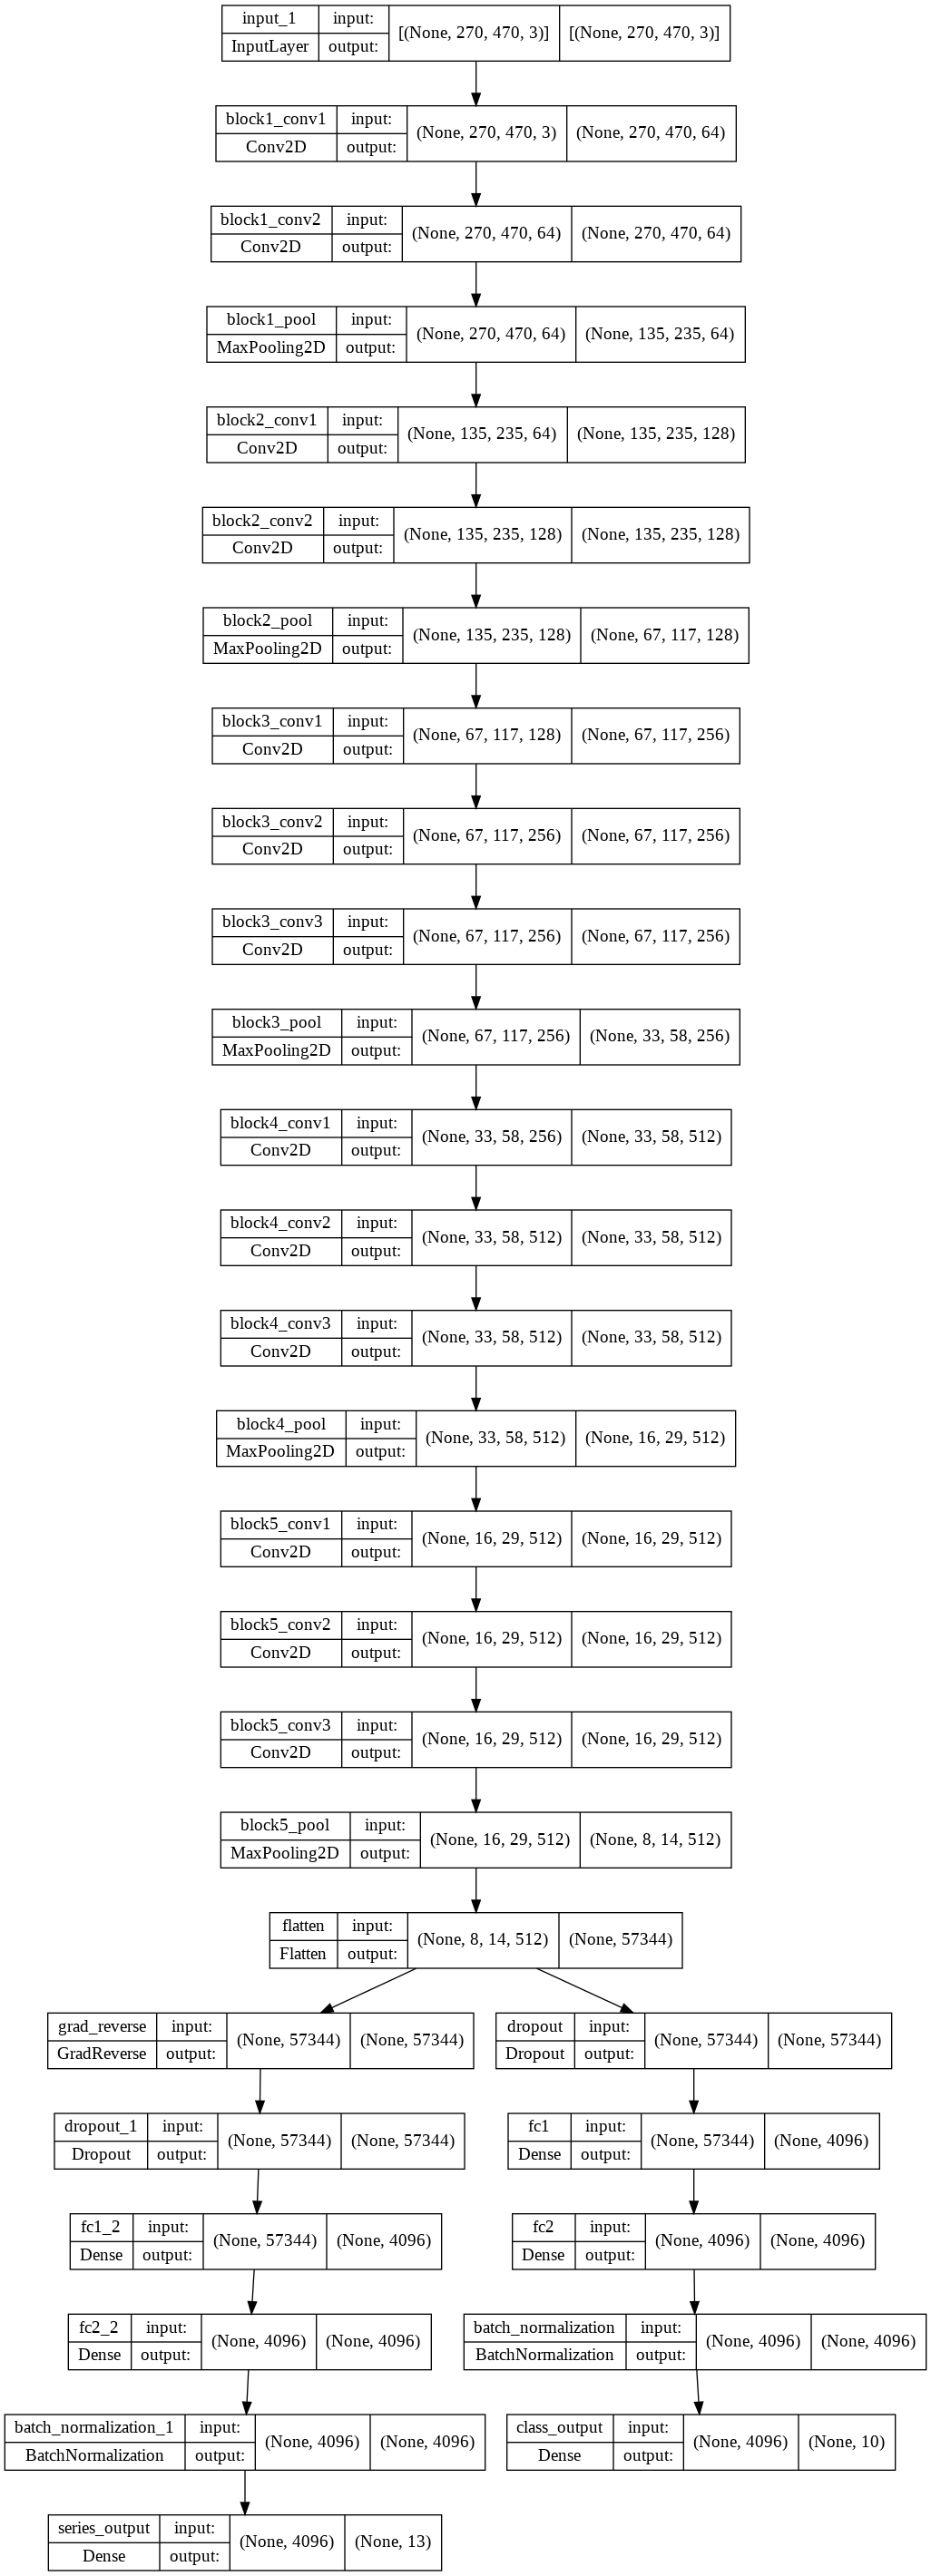

In [12]:
'''NETWORK DEFINITION'''


'''build the top model'''
model = Sequential()

vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))      #pre allenata con immagini di imagenet, e quindi pesi già esistenti dall'inizio, che poi vengono modificati e migliorati
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

##NOTA : in alcune alternative ho visto che applicano il Flatten prima della ramificazione.
top_model = Flatten(name='flatten')(vgg16_conv.output)

'''building the first ramification - quality class classificator'''   
#x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(top_model)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='class_output')(x) #-Prediction_QUALITY_CLASS

'''building the second ramification - domain adaptator (adversarial debiasing), series class classificator'''
#-----------------------
#Gradient reversal layer (per invertire il segno della loss e mantenere una forma di Loss complessiva formata solo da somme)

@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

#-----------------------
#x2 = Flatten(name='flatten2')(vgg16_conv.output)

x2 = GradReverse()(top_model)

x2 = Dropout(0.5)(x2)
x2 = Dense(4096, activation='relu', name='fc1_2')(x2)
x2 = Dense(4096, activation='relu', name='fc2_2')(x2)
x2 = BatchNormalization()(x2)
x2 =  Dense(len(serie), activation='softmax', name='series_output')(x2)   #-Adversarial_Debiasing


'''creating the complete architecture'''

dot_img_file = '/tmp/model_2.png'     #choose a location where save the image model
 
model = keras.Model(vgg16_conv.input, [x, x2], name="quality_recognizer")   #create the complete model ì, with the input and the 2 outputs ramifications

model.summary()    # inspect model in output video

tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)  #plot the model with the shapes


##Metrica Balance Accuracy

In [13]:
import keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''

'''
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
    print("y_true "+format.{y_true})
    print("y_pred "+format.{y_pred})
    C = confusion_matrix(y_true, y_pred)
    print("CM "+format.{C})
  #with np.errstate(divide="ignore", invalid="ignore"):
    per_class = tf.linalg.diag_part(C) / K.sum(axis=1)
    print("per_class "+format.{per_class})
		tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		fn = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
		#sensitivity = tp / (fn + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule
		sensitivity = tp / (fn + tp + K.epsilon()) #--OK

		tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
		fp = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
		#specificity = tn / (fp + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule 
		specificity = tn / (fp + tn + K.epsilon()) #--OK 
	
		Balanced_Accuracy = (sensitivity+specificity)/2 #--OK
		return Balanced_Accuracy 
	return bal_acc
'''

def monitor_balance_accuracy ():
  def class_output_bal_acc(y_true, y_pred):
    Recall0=0
    Recall1=0
    Recall2=0
    Recall3=0
    Recall4=0
    Recall5=0
    Recall6=0
    Recall7=0
    Recall8=0
    Recall9=0

    Recall0 = tf.keras.metrics.Recall(class_id=0)
    Recall0.update_state(y_true, y_pred)
    Recall1 = tf.keras.metrics.Recall(class_id=1)
    Recall1.update_state(y_true, y_pred)
    #rec1 = Recall1.result()
    Recall2 = tf.keras.metrics.Recall(class_id=2)
    Recall2.update_state(y_true, y_pred)
    Recall3 = tf.keras.metrics.Recall(class_id=3)
    Recall3.update_state(y_true, y_pred)
    Recall4 = tf.keras.metrics.Recall(class_id=4)
    Recall4.update_state(y_true, y_pred)
    Recall5 = tf.keras.metrics.Recall(class_id=5)
    Recall5.update_state(y_true, y_pred)
    Recall6 = tf.keras.metrics.Recall(class_id=6)
    Recall6.update_state(y_true, y_pred)
    Recall7 = tf.keras.metrics.Recall(class_id=7)
    Recall7.update_state(y_true, y_pred)
    Recall8 = tf.keras.metrics.Recall(class_id=8)
    Recall8.update_state(y_true, y_pred)
    Recall9 = tf.keras.metrics.Recall(class_id=9)
    Recall9.update_state(y_true, y_pred)

    #v.1 = non fa
    #Mean = K.sum(Recall1.result(),Recall2.result(),Recall3.result(),Recall4.result(),Recall5.result(),Recall6.result(),Recall7.result(),Recall8.result(),Recall9.result())
    Bal_acc = tf.reduce_mean([K.cast(Recall0.result(), dtype='float32'),K.cast(Recall1.result(), dtype='float32'),K.cast(Recall2.result(), dtype='float32'),
                              K.cast(Recall3.result(), dtype='float32'),K.cast(Recall4.result(), dtype='float32'),K.cast(Recall5.result(), dtype='float32'),
                              K.cast(Recall6.result(), dtype='float32'),K.cast(Recall7.result(), dtype='float32'),K.cast(Recall8.result(), dtype='float32'),K.cast(Recall9.result(), dtype='float32'),], keepdims=False)
    #print("ok5 - stampo reduce_mean")
    #print(Bal_acc)
    return (Bal_acc) 
  return class_output_bal_acc



In [14]:
'''
#Object class Balance_Accuracy to perform directly the measure during the epochs from the Sklearn metric

from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input
import keras.backend as K

class BalAccScore(keras.callbacks.Callback):

    def __init__(self, validation_data=None):
        super(BalAccScore, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):
      self.balanced_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
      imgs_array = [] 
      test_array = []
      for index, row in self.validation_data.df.iterrows():
        filename = row['filename'] 
        class_ = int(row['class'])
        test_array.append(class_)
        image = load_img('/content/drive/My Drive/CALCIO_NOPRE/{}'.format(filename), target_size = (immg_rows, immg_cols))
        x = img_to_array(image)
        x = preprocess_input(x)  #non dovrebbe servire
        imgs_array.append(x)
        X_test = np.asarray(imgs_array)



      test_array = np.array(test_array)
      y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
      y_test_no_argmax = y_test
      y_test = y_test.argmax(axis=1)
      y_predict = tf.argmax(self.model.predict(X_test), axis=1)

     
      #y_true = tf.argmax(self.validation_data.df['class'], axis=1) 
      #balacc = balanced_accuracy_score(y_test, y_predict)
      #balacc = balanced_accuracy_score(y_true, y_predict)
      #self.balanced_accuracy.append(round(balacc,6))
      #logs["val_bal_acc"] = balacc
      #keys = list(logs.keys())

      balacc = balanced_accuracy_score(y_test, y_predict)
      self.balanced_accuracy.append(round(balacc,6))
      logs["val_bal_acc"] = balacc
      keys = list(logs.keys())

      print("\n ------ validation balanced accuracy score: %f ------\n" %balacc)
'''

'\n#Object class Balance_Accuracy to perform directly the measure during the epochs from the Sklearn metric\n\nfrom tensorflow.keras import Model\nfrom keras.applications.vgg16 import preprocess_input\nimport keras.backend as K\n\nclass BalAccScore(keras.callbacks.Callback):\n\n    def __init__(self, validation_data=None):\n        super(BalAccScore, self).__init__()\n        self.validation_data = validation_data\n        \n    def on_train_begin(self, logs={}):\n      self.balanced_accuracy = []\n\n    def on_epoch_end(self, epoch, logs={}):\n      imgs_array = [] \n      test_array = []\n      for index, row in self.validation_data.df.iterrows():\n        filename = row[\'filename\'] \n        class_ = int(row[\'class\'])\n        test_array.append(class_)\n        image = load_img(\'/content/drive/My Drive/CALCIO_NOPRE/{}\'.format(filename), target_size = (immg_rows, immg_cols))\n        x = img_to_array(image)\n        x = preprocess_input(x)  #non dovrebbe servire\n        imgs_a

## Callbacks 

In [15]:
'''CALLBACKS'''
from keras.callbacks import ModelCheckpoint, EarlyStopping
#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

#model_checkpoint = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)
model_checkpoint_val_bal_acc = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_bal_acc', verbose=1, save_best_only=True)
model_checkpoint_val_loss = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)

#early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

### MODIFICATO QUA - Implementazione Early Stopping###
early_stopping_val_bal_acc = tf.keras.callbacks.EarlyStopping(
    monitor='val_bal_acc', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=10, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=10, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
callbacks=[model_checkpoint_val_bal_acc, model_checkpoint_val_loss , early_stopping_val_loss, early_stopping_val_bal_acc ]

##HYPERPARAMETERS


The **optimization algorithm** (or optimizer) is the main approach used today for training a machine learning model to minimize its error rate. There are *two metrics* to determine the efficacy of an optimizer: **speed of convergence** (the process of reaching a global optimum for gradient descent); and **generalization** (the model’s performance on new data)

***SGD*** : Stochastic Gradient Descent 

Parameters 
- Learning : learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. ... In setting a learning rate, there is a trade-off between the rate of convergence and overshooting
- Momentum : Momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- Decay :  We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb) ... lr = (lr_iniziale - (1.0/(1-decay*iterations)))
- Nesterov: Nesterov which is set to false by default. Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions.

[1° LINK](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

[2° LINK](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)


***ADAM*** :  Adaptive Moment Estimation




FONTI : Paper for ICLR 2019

In [16]:
'''HYPERPARAMETERS DEFINITION'''
#per la stampa dei tensori 
import keras.backend as K   
                                              #ho invertito le loss e i lossweigh perchè in modello nel NETWORK sono in quell'ordine                                                                                                    
test_array_s0 = []
pred_array_s0 = []
i=0

#opt = Adam(learning_rate=0.00001)
opt = SGD(learning_rate = 0.0001, decay = 1e-4, momentum= 0.9)

num_epochs = 100 #era 100
#num_epochs = 100 #era 100
bs = 32 #era 16 
#model.compile(loss=loss, optimizer=opt, metrics = ['accuracy']) 

# è il link che ti ho inviato su teams 
# To do : capire come dividere y_pred, y_true per ogni serie 
# https://github.com/aws-samples/amazon-sagemaker-custom-loss-function/blob/master/custom-loss/Training_Models_with_Unequal_Economic_Error_Costs.ipynb


#losses = {
#	"class_output": "categorical_crossentropy",
# "series_output": "categorical_crossentropy",
#}
class_weights = weight_train
print('Class Weight Train : {} '.format(class_weights))
print('Type Class Weight Train : {} '.format(type(class_weights)))

data = list(class_weights.values())
class_weights = np. array(data)
print('Class Weight Train : {} '.format(class_weights))

losses = {
	"class_output": weighted_categorical_crossentropy(class_weights).loss,
  "series_output": "categorical_crossentropy" 
}

lossWeights = {"class_output": 1.0, "series_output": 0.5}

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy",monitor_balance_accuracy()], run_eagerly=True)
 

Class Weight Train : {0: 1.34, 1: 1.53, 2: 0.97, 3: 1.16, 4: 1.15, 5: 0.71, 6: 0.62, 7: 1.02, 8: 0.75, 9: 2.05} 
Type Class Weight Train : <class 'dict'> 
Class Weight Train : [1.34 1.53 0.97 1.16 1.15 0.71 0.62 1.02 0.75 2.05] 


In [17]:
'''
def custom_loss_wrapper(fn_cost=1, fp_cost=1):
    def custom_loss(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost):
        ### prove denis 16/09
        #y_true = K.print_tensor(y_true, message='y_true = ') #stampa il tensore 

        ## O PROVATO AD UTILIZZARE IL METODO GIA' IMPLEMENTATO PER DIVIDERE LE SERIE ... L'UNICO DUBBIO CHE MI RESTA è CAPIRE COME LAVORA CON I VARI DATAFRAME 
        for index, row in test_balance_df.iterrows():
            series_ = int(row['series'])
            if series_ == 0:
              test_array_s0.append(y_true[i])
              pred_array_s0.append(y_pred[i])
        print('test_array_s0 shape {}'.format(len(test_array_s0)))

        for index, row in train_balance_df.iterrows():
            series_ = int(row['series'])
            if series_ == 0:
              test_array_s0.append(y_true[i])
              pred_array_s0.append(y_pred[i])
        print('test_array_s0 train shape {}'.format(len(test_array_s0)))
        h = K.ones_like(y_pred)
        fn_value = fn_cost * h
        fp_value = fp_cost * h

        weighted_values = y_true * K.abs(1-y_pred)*fn_value + (1-y_true) * K.abs(y_pred)*fp_value

        loss = K.mean(weighted_values)
        return loss
        
    return custom_loss
  
custom_loss_medical = custom_loss_wrapper(fn_cost=200, fp_cost=1)
'''

"\ndef custom_loss_wrapper(fn_cost=1, fp_cost=1):\n    def custom_loss(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost):\n        ### prove denis 16/09\n        #y_true = K.print_tensor(y_true, message='y_true = ') #stampa il tensore \n\n        ## O PROVATO AD UTILIZZARE IL METODO GIA' IMPLEMENTATO PER DIVIDERE LE SERIE ... L'UNICO DUBBIO CHE MI RESTA è CAPIRE COME LAVORA CON I VARI DATAFRAME \n        for index, row in test_balance_df.iterrows():\n            series_ = int(row['series'])\n            if series_ == 0:\n              test_array_s0.append(y_true[i])\n              pred_array_s0.append(y_pred[i])\n        print('test_array_s0 shape {}'.format(len(test_array_s0)))\n\n        for index, row in train_balance_df.iterrows():\n            series_ = int(row['series'])\n            if series_ == 0:\n              test_array_s0.append(y_true[i])\n              pred_array_s0.append(y_pred[i])\n        print('test_array_s0 train shape {}'.format(len(test_array_s0)))\n        h = K

###PROVE DI LOSS CUSTOMIZZATA

In [18]:
"""
logitss = x2
# ANCHE QUESTO CI VA PERCHè RAPPRESENTA L'ULTIMO PASSO CHE RAPPRESENTA LA FIGURA 2.1B DEL PAPER DI LISA GOERKE (QUADRATO SOFTMAX, DOVE LI è BINARIO PERCHè HA SOLO 2 SCELTE, QUI INVECE len(classi)=10)
print(logitss.shape)
print(logitss)


###### PROVE ALEX #######
series = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
logits = logitss      #così i logits sono presi dal layer interessato dell'adversarial debiasing ramification
labels_ph = series
print(labels_ph.shape)
print(labels_ph)
# your class weights
class_weights = tf.constant([[1.0, 2.0, 3.0]])
# deduce weights for batch samples based on their true label
weights = tf.reduce_sum(class_weights * onehot_labels, axis=1)
# compute your (unweighted) softmax cross entropy loss
unweighted_losses = tf.nn.softmax_cross_entropy_with_logits(onehot_labels, logits)
# apply the weights, relying on broadcasting of the multiplication
weighted_losses = unweighted_losses * weights
# reduce the result to get your final loss
loss = tf.reduce_mean(weighted_losses)


###### PROVE DENIS #######
def loss_function_1():
  classi = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  logits_ph = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  labels_ph = classi
  wheight_ph = class_weight.compute_class_weight('balanced',train_balance_df['class'].unique(),train_balance_df['class'])
  weight_ph_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
  #print('Weigh train_balance_df')
  weight_ph_train = list(weight_ph_train.values())
  #print(weight_ph_train)
  weighted_labels = [a * b for a, b in zip(labels_ph, weight_ph_train)]
  weighted_labels = tf.convert_to_tensor(weighted_labels, dtype=tf.float32)
  logits_ph = tf.convert_to_tensor(logits_ph, dtype=tf.float32)
  #print('weighted_labels')
  #print(weighted_labels)
  loss1 = tf.nn.softmax_cross_entropy_with_logits(labels=weighted_labels, logits=logits_ph)
  print('loss classi: {} '.format(loss1))
  return loss1


def loss_function_2():
  series = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  logits_ph = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  labels_ph = series
  wheight_ph = class_weight.compute_class_weight('balanced',train_balance_df['series'].unique(),train_balance_df['series'])
  weight_ph_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
  weight_ph_train = list(weight_ph_train.values())
  weighted_labels = [a * b for a, b in zip(labels_ph, weight_ph_train)]
  weighted_labels = tf.convert_to_tensor(weighted_labels, dtype=tf.float32)
  logits_ph = tf.convert_to_tensor(logits_ph, dtype=tf.float32)
  loss2 = tf.nn.softmax_cross_entropy_with_logits(labels=weighted_labels, logits=logits_ph)
  print('loss series : {} '.format(loss2))
  return loss2


  #model.compile(loss=[loss_function_1(),loss_function_2()], optimizer=opt, metrics = ['accuracy']) 




#classesLabelsTrain = []
#seriesLabelsTrain = []
#classesLabelsVal = []
#seriesLabelsVal = []

#for index, row in train_balance_df.iterrows():
#    seriesLabelsTrain.append(row['series'])
#    classesLabelsTrain.append(row['class'])
#for index, row in val_balance_df.iterrows():
#    seriesLabelsVal.append(row['series'])
#    classesLabelsVal.append(row['class'])

#classesLabelsTrain = np.array(classesLabelsTrain)
#seriesLabelsTrain = np.array(seriesLabelsTrain)
#classesLabelsVal = np.array(classesLabelsVal)
#seriesLabelsVal = np.array(seriesLabelsVal)

# binarize both sets of labels
#print("[INFO] binarizing labels...")
#classesLB = LabelBinarizer()
#seriesLB = LabelBinarizer()

#classesLabelsTrain = classesLB.fit_transform(classesLabelsTrain)
#seriesLabelsTrain = seriesLB.fit_transform(seriesLabelsTrain)
#classesLabelsVal = classesLB.fit_transform(classesLabelsVal)            #FORSE IN QUESTE FACENDOLE SEPARATE DA QUELLE DEL TRAIN USA POI VALORI DIVERSI??
#seriesLabelsVal = seriesLB.fit_transform(seriesLabelsVal)

#history = model.fit(x=traingen,validation_data=(valgen, {"classe_qual": classesLabelsVal, "serie_geom": seriesLabelsVal}), epochs=num_epochs, callbacks = callbacks, verbose=1)
"""

'\nlogitss = x2\n# ANCHE QUESTO CI VA PERCHè RAPPRESENTA L\'ULTIMO PASSO CHE RAPPRESENTA LA FIGURA 2.1B DEL PAPER DI LISA GOERKE (QUADRATO SOFTMAX, DOVE LI è BINARIO PERCHè HA SOLO 2 SCELTE, QUI INVECE len(classi)=10)\nprint(logitss.shape)\nprint(logitss)\n\n\n###### PROVE ALEX #######\nseries = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]\nlogits = logitss      #così i logits sono presi dal layer interessato dell\'adversarial debiasing ramification\nlabels_ph = series\nprint(labels_ph.shape)\nprint(labels_ph)\n# your class weights\nclass_weights = tf.constant([[1.0, 2.0, 3.0]])\n# deduce weights for batch samples based on their true label\nweights = tf.reduce_sum(class_weights * onehot_labels, axis=1)\n# compute your (unweighted) softmax cross entropy loss\nunweighted_losses = tf.nn.softmax_cross_entropy_with_logits(onehot_labels, logits)\n# apply the weights, relying on broadcasting of the multiplication\nweighted_losses = unweighted_losses * weights\n# reduce the result to get your fi

## Testing Model 

In [19]:
'''TRAINING THE MODEL'''
from sklearn.preprocessing import LabelBinarizer

"""
#PARTE ALLENAMENTO CON IMMAGINI MASCHERATE
traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470), class_weights = weight_train)       #verifica weights train
testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))
"""

#PARTE ALLENAMENTO IMMAGINI NORMALI
traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))       #verifica weights train
testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))



#history = model.fit(traingen,validation_data=valgen, epochs=num_epochs, callbacks = callbacks, verbose=1)       #OLD VERSION

history = model.fit(x=traingen,validation_data=valgen, epochs=num_epochs, callbacks = callbacks, verbose=1)
print(history.history.keys()) #---serve per stampare le metriche che ho nel modello 



[INFO] performing 'on the fly' data augmentation
[INFO] performing 'on the fly' data augmentation
[INFO] performing 'on the fly' data augmentation
Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 7.5238 - class_output_loss: 6.1033 - series_output_loss: 2.8410 - class_output_accuracy: 0.1627 - class_output_class_output_bal_acc: 0.0516 - series_output_accuracy: 0.1571 - series_output_class_output_bal_acc: 0.0209 WARNING:tensorflow:Can save best model only with val_bal_acc available, skipping.

Epoch 1: val_loss improved from inf to 6.33085, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5
39/39 [==============================] - 862s 22s/step - loss: 7.5238 - class_output_loss: 6.1033 - series_output_loss: 2.8410 - class_output_accuracy: 0.1627 - class_output_class_output_bal_acc: 0.0516 - series_output_accuracy: 0.1571 - series_output_class_output_bal_acc: 0.0209 - val_loss: 6.3309 - val_class_output_loss: 5.2955 - va

In [20]:
print("Conta del numero di immagini per specifica classe in set Train")
print(traingen.classi_augmented)

#####QUESTI PRINT SERVONO SOLO DI VERIFICA SE SOPRA STAMPA CORRETTAMENTE ... GLI ELEMENTI DI SERIE 1 (SONO DEI TEST) UNA VOLTA FINITA CANCELLARE
k = 0
for index, row in test_balance_df.iterrows():
            series_ = int(row['series'])
            if series_ == 0:
              k=k+1
print('k - test : {}'.format(k))

k = 0
for index, row in train_balance_df.iterrows():
            series_ = int(row['series'])
            if series_ == 0:
              k=k+1
print('k - test : {}'.format(k))

Conta del numero di immagini per specifica classe in set Train
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
k - test : 26
k - test : 78


## PLOT 

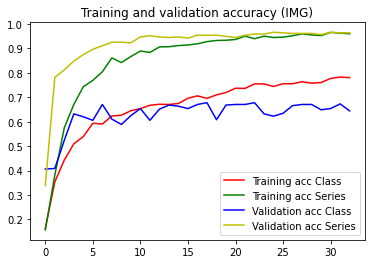

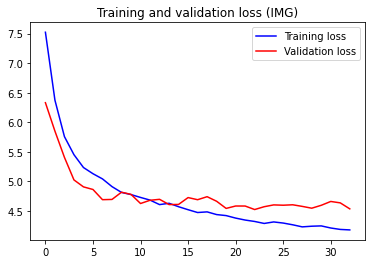

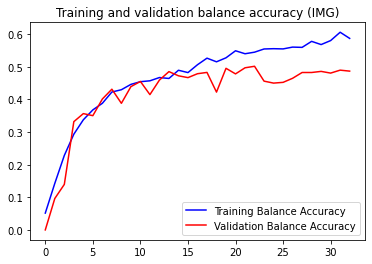

In [22]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc_class = history.history['class_output_accuracy']
acc_series = history.history['series_output_accuracy']
#acc = history.history['accuracy'] ##---- modificato sopra
#val_acc = history.history['val_accuracy'] #---- modificato sotto 
val_acc_class = history.history['val_class_output_accuracy']
val_acc_series = history.history['val_series_output_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
class_output_bal_acc = history.history['class_output_class_output_bal_acc']
val_class_output_bal_acc = history.history['val_class_output_class_output_bal_acc']
lista = [acc_class,acc_series,val_acc_class,val_acc_series,loss,val_loss,class_output_bal_acc,val_class_output_bal_acc] #--- modificato 


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc_class))

plt.plot(epochs, acc_class, 'r', label='Training acc Class') 
plt.plot(epochs, acc_series, 'g', label='Training acc Series') 
plt.plot(epochs, val_acc_class, 'b', label='Validation acc Class') 
plt.plot(epochs, val_acc_series, 'y', label='Validation acc Series')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

plt.figure()

plt.plot(epochs, class_output_bal_acc, 'b', label='Training Balance Accuracy')
plt.plot(epochs, val_class_output_bal_acc, 'r', label='Validation Balance Accuracy')
plt.title('Training and validation balance accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

### SAVE MODEL 

In [23]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/Final/assets
Saved model to disk


## LOAD MODEL 

In [24]:
'''LOAD THE SAVED MODEL'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)

path_model = os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn))

model = load_model(path_model, compile=False) #-- errore con custom loss
#model = load_model(path_model, custom_objects={"CustomModel": Model} #--- per caricare il modelo in teoria 
#ValueError: Unknown loss function: custom_loss. Please ensure this object is passed to the `custom_objects` argument. 
#https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
print('Model IMG Loaded')


Model IMG Loaded


## PREDICTION 

In [36]:
'''EXECUTE PREDICTIONS FROM THE TRAINED MODEL'''

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input

test_array = []
test_array_series = []

for index, row in test_balance_df.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   

y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
y_test_series = to_categorical(np.unique(test_array_series, return_inverse=True)[1]) 

imgs_array = [] 


'''carico le immagini del sub-set di test'''
for index, row in testgen.df.iterrows():
    filename = row['filename']       
    image = load_img(os.path.join(path_IMAGES, filename), target_size = (immg_rows, immg_cols))
    x = img_to_array(image)
    x = preprocess_input(x)  #non dovrebbe servire
    imgs_array.append(x)
    X_test = np.asarray(imgs_array)


In [38]:
######PARTE DA FINIRE DI SISTEMARE
y_test_no_argmax = y_test

y_test = y_test.argmax(axis=1)
y_test_series = y_test_series.argmax(axis=1)      

'''predictions'''
y_pred = model.predict(X_test)

#---------------
#metriche nuove senza usare argmax.
#---------------
y_pred_no_argmax = y_pred[0]            #--- modificato qua aggiungendo y_pred[0] invece di y_pred
y_pred = np.argmax(y_pred[0],axis=1)    #--- modificato qua aggiungendo y_pred[0] invece di y_pred

print(y_pred)
print(y_test)

print(y_pred_no_argmax.shape)
print(y_test_no_argmax.shape)

#y_pred_conf = model.predict(X_test)
#index = np.where(np.equal(y_pred, y_test) == False)[0]
#print(np.around(y_pred_conf[index], decimals = 2))

"""
#alcune verifiche visive sull'intero sub-set di test
print(y_test)
print(y_test.shape)
print(y_test_series)
print(y_test_series.shape)
print(y_pred)
print(y_pred.shape)
"""

AxisError: ignored

In [ ]:
dataset_bias_test = test_balance_df.copy()  #10/09
dataset_bias_test.scores = y_pred           #10/09
#dataset_bias_test.labels = test_balance_df.labels #10/09
print(dataset_bias_test.scores)
print(dataset_bias_test)

##SEARCH UNIVOQUE SERIES TO BALANCE SETS

In [ ]:
'''SEARCHING UNIVOQUE SERIES'''

'''serve per fare le stampe delle confusion matrix per ciascuna serie di appartenenza delle immagini del sub-set test'''
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

a = accuracy_score(y_test, y_pred)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy:",a)
print("precision:", precision_score(y_test, y_pred , average="macro"))          # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall:", recall_score(y_test, y_pred , average="macro"))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score:", f1_score(y_test, y_pred , average="macro"))                  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test, y_pred))  



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

In [33]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [34]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#errore no graph before run 
tf.compat.v1.disable_eager_execution()



def compute_metrics(y_true, y_pred, num_classes):

  #run function minimum_sensitivity


  # Calculate metric
  sess = keras.backend.get_session()

  #qwk = np_quadratic_weighted_kappa(np.argmax(y_true, axis=0), np.argmax(y_pred, axis=0), 0,
	#									num_classes - 1)
  
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  ms = minimum_sensitivity(y_test_no_argmax, y_pred_no_argmax)
  mae = sess.run(K.mean(keras.losses.mean_absolute_error(y_test_no_argmax, y_pred_no_argmax)))
  
  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae}
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10
metrics = compute_metrics(y_test, y_pred,num_classi)
print_metrics(metrics)

with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)





QWK: 0.4110
MS: 0.0000
MAE: 0.1562


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
'''METHOD FOR PLOT CONFUSION MATRIX'''
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

In [ ]:
'''PLOT ENTIRE CONFUSION MATRIX OF THE SUB-SET TEST'''

import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 




##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

In [ ]:
'''PLOT CONFUSION MATRIX FOR EACH DISTINCT SERIES OF PRODUCTION PRESENT INTO THE SUB-SET TEST'''

import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
plt.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
plt.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
plt.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
plt.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
plt.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
plt.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
plt.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
plt.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
plt.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
plt.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
plt.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
plt.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 

#serie 12
cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
plt.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
'''CRAMER V CORRELATION MEASUREMENT'''


'''PRIMA VERSIONE'''
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print(cramer1)

confusion_matrix2 = pd.crosstab(y_test_series, y_pred)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)



'''SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo'''
contTable = pd.crosstab(y_test_series, y_pred)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

# METRICHE DI MISURAZIONE BIAS

#PROVE METRICHE  (NON ORA) 

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

import numpy as np
import sklearn.datasets
import pandas as pd
import sklearn.preprocessing as preprocessing
from collections import namedtuple
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

'''metrics functions definition'''
import numpy as np
from sklearn.metrics import confusion_matrix

def equalized_odds_measure_TP(data, model, sensible_features, ylabel, rev_pred=1, nostro=0, y_pred= None):
    if nostro != 0:
      predictions = y_pred
    else:
      predictions = model.predict(data.data) * rev_pred
    
    truth = data.target
    eq_dict = {}
    for feature in sensible_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict


def equalized_odds_measure_TP_no_sensitive(data, model, sensible_features, ylabel, rev_pred=1):
    newdata = np.delete(data.data, sensible_features, 1)
    predictions = model.predict(newdata) * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensible_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict


def equalized_odds_measure_TP_from_list_of_sensfeat(data, model, sensible_features, ylabel, rev_pred=1):
    predictions = model.predict(data.data) * rev_pred
    truth = data.target
    eq_dict = {}
    for idf, features in enumerate(sensible_features):
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(features))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if features[i] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and features[i] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[idf] = eq_sensible_feature
    return eq_dict


def equalized_odds_measure_from_pred_TP(data, pred, sensible_features, ylabel, rev_pred=1):
    predictions = pred * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensible_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict


def equalized_odds_measure_FP(data, model, sensible_features, ylabel, rev_pred=1):
    predictions = model.predict(data.data) * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensible_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] != ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] != ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict


# TODO: check this
def false_omission_rate(data, model, sensible_features, ylabel):
    predictions = model.predict(data.data)
    truth = data.target
    eq_dict = {}
    for feature in sensible_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] != ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] != ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict


def statistical_parity_measure(data, model, sensible_features, ylabel, nostro=0, y_pred= None):
    if nostro != 0:
      predictions = y_pred
    else:
      predictions = model.predict(data.data)
    #predictions = y_pred
    sp_dict = {}
    for feature in sensible_features:
        sp_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            sp_tmp = None
            n_sensitive = np.sum([1.0 if data.data[i, feature] == val else 0.0 for i in range(len(predictions))])
            if n_sensitive > 0:
                sp_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val else 0.0
                                 for i in range(len(predictions))]) / n_sensitive
            sp_sensible_feature[val] = sp_tmp
        sp_dict[feature] = sp_sensible_feature
    return sp_dict


def disparate_impact_measure(data, model, sensible_features, nostro=0, y_pred= None):
    di_dict = statistical_parity_measure(data, model, sensible_features, ylabel=1, nostro = nostro, y_pred=y_pred)
    for feature in di_dict:
        values_of_sensible_feature = list(set(data.data[:, feature]))
        if len(values_of_sensible_feature) != 2:
            di_dict[feature] = {}
        else:
            di_dict[feature] = np.min([di_dict[feature][values_of_sensible_feature[0]] /
                                       di_dict[feature][values_of_sensible_feature[1]],
                                       di_dict[feature][values_of_sensible_feature[1]] /
                                       di_dict[feature][values_of_sensible_feature[0]]])
    return di_dict

def subgrups_sensible_feature(data, sensible_feature):
    dict_idxs = {}
    values_of_sensible_feature = list(set(data.data[:, sensible_feature]))
    for val in values_of_sensible_feature:
        dict_idxs[val] = [idx for idx, x in enumerate(data.data) if x[sensible_feature] == val]
    return dict_idxs

def fair_tpr_from_model(data, model, sensible_feature, nostro=0, y_pred= None):
    if nostro != 0:
      predictions = y_pred
    else:
      predictions = model.predict(data.data)
    truth = data.target
    dict_idxs = subgrups_sensible_feature(data, sensible_feature)
    for val in dict_idxs:
        dict_idxs[val] = tpr(truth[dict_idxs[val]], predictions[dict_idxs[val]])
    return dict_idxs

def tpr(y_true, y_pred):
    if len(confusion_matrix(y_true, y_pred).ravel()) <= 3:
        return 1.0
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if tp + fn == 0:
        return 1.0
    return float(tp) / float(tp + fn)

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return float(fp) / float(fp + tn)


In [ ]:
'''TEST BIAS METRICS CLASSIFICATIONS'''

'''load dataset of the example code & set some attributes(target, data)'''
dataset = sklearn.datasets.load_diabetes()
# Make the target binary: high progression Vs. low progression of the disease
dataset.target = np.array([1 if diabetes_progression > 139 else -1 for diabetes_progression in dataset.target])
val0 = np.min(dataset.data[0, 1])
dataset.data[:, 1] = [0 if val == val0 else 1 for val in dataset.data[:, 1]]
diabetes = dataset
# 50% for train
ntrain = len(diabetes.target) // 2

'''train a model to get predictions inside methods'''
# Train an SVM using the training set
clf = svm.SVC(C=10.0)
clf.fit(diabetes.data[:ntrain, :], diabetes.target[:ntrain])
# The dataset becomes the test set
diabetes.data = diabetes.data[ntrain:, :]
diabetes.target = diabetes.target[ntrain:]
print('-----------------MISURE REPOSITORY CON DATASET DA INTERNET-------------------')
# Fairness measure
# Accuracy
pred = clf.predict(diabetes.data)
print('Accuracy:',  accuracy_score(diabetes.target, pred))
print('equalized_odds_measure_TP')
print(equalized_odds_measure_TP(diabetes, clf, [1], ylabel=1))  
idxs = subgrups_sensible_feature(diabetes, sensible_feature=1)
print('fair_tpr_from_model')
print(fair_tpr_from_model(diabetes, clf, sensible_feature=1))
print('disparate_impact_measure')
print(disparate_impact_measure(diabetes, clf, sensible_features=[0,1]))

print('-----------------MISURE NOSTRE -------------------')
###DATAFRAME CHE VOGLIAMO 
###[INDICE, SERIE(variabile sensibile), CLASSE, IMG...]
#print('len df testgen : {} '.format(len(testgen.df)))
#print(testgen.df.shape)
#diabets_nostro.data = testgen.df.to_numpy()
#print('len df testgen DOPO : {} '.format(len(diabets_nostro.data)))
#print(diabets_nostro.data)
#print(diabets_nostro.data.shape)
#diabets_nostro.target = testgen.df['class'].to_numpy()
#print('target : {}'.format(diabets_nostro.target))

from sklearn.utils import Bunch
diabets_nostro = Bunch(data=testgen.df.to_numpy(), target=testgen.df['class'].to_numpy())


# Accuracy
pred = y_pred
print('Accuracy (NOSTRO):',  accuracy_score(diabets_nostro.target, pred))
print('equalized_odds_measure_TP (NOSTRO)')
print(equalized_odds_measure_TP(diabets_nostro, model, [1], ylabel=[3], nostro=1, y_pred=y_pred))  
idxs = subgrups_sensible_feature(diabets_nostro, sensible_feature=1)
print('fair_tpr_from_model (NOSTRO)')
#print(fair_tpr_from_model(diabets_nostro, model, sensible_feature=1,nostro=1, y_pred=y_pred))
print('disparate_impact_measure (NOSTRO)')
print(disparate_impact_measure(diabets_nostro, model, sensible_features=[1], nostro=1, y_pred=y_pred)) ### non da errore, ma non da nemmeno risultati ... bisogna studiare meglio il metodo

#diabetes.data = diabetes.data[ntrain:, :]
#diabetes.target = diabetes.target[ntrain:]

# Metriche Lisa

## Alcune Definizioni 
*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
y_true = testgen.df['class'].to_numpy()
SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####

Balanced_Accuracy_s0= sk.metrics.balanced_accuracy_score(test_array_s0, pred_array_s0, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 0 : {}' . format(Balanced_Accuracy_s0))

Balanced_Accuracy_s1= sk.metrics.balanced_accuracy_score(test_array_s1, pred_array_s1, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 1 : {}' . format(Balanced_Accuracy_s1))

Balanced_Accuracy_s2= sk.metrics.balanced_accuracy_score(test_array_s2, pred_array_s2, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 2 : {}' . format(Balanced_Accuracy_s2))

Balanced_Accuracy_s3= sk.metrics.balanced_accuracy_score(test_array_s3, pred_array_s3, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 3 : {}' . format(Balanced_Accuracy_s3))

Balanced_Accuracy_s4= sk.metrics.balanced_accuracy_score(test_array_s4, pred_array_s4, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 4 : {}' . format(Balanced_Accuracy_s4))

Balanced_Accuracy_s5= sk.metrics.balanced_accuracy_score(test_array_s5, pred_array_s5, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 5 : {}' . format(Balanced_Accuracy_s5))

Balanced_Accuracy_s6= sk.metrics.balanced_accuracy_score(test_array_s6, pred_array_s6, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 6 : {}' . format(Balanced_Accuracy_s6))

Balanced_Accuracy_s7= sk.metrics.balanced_accuracy_score(test_array_s7, pred_array_s7, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 7 : {}' . format(Balanced_Accuracy_s7))

Balanced_Accuracy_s8= sk.metrics.balanced_accuracy_score(test_array_s8, pred_array_s8, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 8 : {}' . format(Balanced_Accuracy_s8))

Balanced_Accuracy_s9= sk.metrics.balanced_accuracy_score(test_array_s9, pred_array_s9, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 9 : {}' . format(Balanced_Accuracy_s9))

Balanced_Accuracy_s10= sk.metrics.balanced_accuracy_score(test_array_s10, pred_array_s10, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 10 : {}' . format(Balanced_Accuracy_s10))

Balanced_Accuracy_s11= sk.metrics.balanced_accuracy_score(test_array_s11, pred_array_s11, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 11 : {}' . format(Balanced_Accuracy_s11))

#--------------se lavoriamo con img non croppate, manca la serie 7 mappata come serie 12 ----------------
#Balanced_Accuracy_s12= sk.metrics.balanced_accuracy_score(test_array_s12, pred_array_s12, sample_weight=None, adjusted=False)
#print('Balanced Accuracy Series 12 : {}' . format(Balanced_Accuracy_s12))

#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Sum = Balanced_Accuracy_s0 + Balanced_Accuracy_s1 + Balanced_Accuracy_s2 + Balanced_Accuracy_s3 + Balanced_Accuracy_s4 + Balanced_Accuracy_s5 + Balanced_Accuracy_s6 + Balanced_Accuracy_s7 + Balanced_Accuracy_s8 + Balanced_Accuracy_s9 + Balanced_Accuracy_s10 + Balanced_Accuracy_s11 #+ Balanced_Accuracy_s12 
Average = Sum/12
print('Average Balanced Accuracy : {}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

In [ ]:
#---- metriche lisa ----#
y_true = testgen.df['class'].to_numpy()
SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#LINK : https://kozodoi.me/r/fairness/packages/2020/05/01/fairness-tutorial.html#Demographic-parity
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##PROVA MDSS (ATTUALMENTE NON FUNZIONA)

In [ ]:
'''imports'''
'''Importing packages & libraries for Bias metrics from AIF360 (end page analysis)'''

"""
import sys
import itertools
import datetime

### altri package necessari 
!pip install tempeh -q --force-reinstall
!pip install fairlearn -q --force-reinstall
!pip install GitPython -q --force-reinstall

#download aif360 
#!pip install -r requirement.txt 
#!python setup.py
###test  errore nella foto 

#!pip uninstall scikit-learn -q -y 
# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704
# INSTALL CONDA ON GOOGLE COLAB
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
# INSTALL PACKAGE CON CONDA 
#!conda install -c conda-forge scikit-learn -y 

## package necessario utile per il gitclone
from git import Repo

date_ = datetime.datetime.now()
#Repo.clone_from("link ... .git", "path di salvataggio")
#Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360_repo_{}".format(date_))
Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360") #controllare sempre, se è già salvato ... se salvato basta commentarlo

#---serve per aggiungere un nuovo package alla lista dei package installati
sys.path.append('/content/aif360/')


from aif360.metrics.mdss.ScoringFunctions import Bernoulli, ScoringFunction 
from aif360.metrics.mdss import MDSS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
import numpy as np
import pandas as pd

from collections import defaultdict
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
"""

In [ ]:
"""from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex', 'race'],
                 privileged_classes=[[1], [1]],
                 instance_weights_name=None)"""

In [ ]:
"""
# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall

#https://github.com/Trusted-AI/AIF360
'''REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI'''
#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb
'''file dove il tipo fa un esempio di uso di questa metrica!'''
#https://aif360.readthedocs.io/en/latest/index.html
'''link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO'''


class MDSSClassificationMetric(ClassificationMetric):
    '''
        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].
        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.
    References:
        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint arXiv:1611.08292.
    '''
    def __init__(self, dataset: BinaryLabelDataset, classified_dataset: BinaryLabelDataset, 
                scoring_function: ScoringFunction = Bernoulli(direction='positive'), unprivileged_groups: dict = None, privileged_groups:dict = None):
    
        super(MDSSClassificationMetric, self).__init__(dataset, classified_dataset,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        
        self.scanner = MDSS(scoring_function)
    
    def score_groups(self, privileged=True, penalty = 1e-17):
        '''
        compute the bias score for a prespecified group of records.
        
        :param privileged: flag for group to score - privileged group (True) or unprivileged group (False).
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the score for the group
        '''
        groups = self.privileged_groups if privileged else self.unprivileged_groups
        subset = dict()
        
        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'

        for g in groups:
            for k, v in g.items():
                if k in subset.keys():
                    subset[k].append(v)
                else:
                    subset[k] = [v]
        
        coordinates = pd.DataFrame(self.dataset.features, columns=self.dataset.feature_names)
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        self.scanner.scoring_function.kwargs['direction'] = direction
        return self.scanner.score_current_subset(coordinates, expected, outcomes, dict(subset), penalty)
    
    def bias_scan(self, privileged=True, num_iters = 10, penalty = 1e-17):
        '''
        scan to find the highest scoring subset of records
        
        :param privileged: flag for group to scan for - privileged group (True) or unprivileged group (False). 
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param num_iters: number of iterations (random restarts)
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the highest scoring subset and the score
        '''

        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'
        self.scanner.scoring_function.kwargs['direction'] = direction

        coordinates = pd.DataFrame(self.classified_dataset.features, columns=self.classified_dataset.feature_names)
        
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        return self.scanner.scan(coordinates, expected, outcomes, penalty, num_iters)

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

#import requests
#url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
#r = requests.get(url, allow_redirects=True)
#open('dataset.csv', 'wb').write(r.content)
#dataset_orig = pd.read_csv('/content/dataset.csv', sep=",")  


series_group = [{'series': 0, 'series': 1, 'series': 2, 'series': 3, 'series': 4, 'series': 5, 'series': 6, 'series': 7, 'series': 8, 'series': 9, 'series': 10, 'series': 11, 'series': 12}]
classes_group = [{'class': 0, 'class': 1, 'class': 2, 'class': 3, 'class': 4, 'class': 5, 'class': 6, 'class': 7, 'class': 8, 'class': 9}]

"""



In [ ]:
"""

mdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,
                         unprivileged_groups=male_group,
                         privileged_groups=female_group)


mdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,
                         unprivileged_groups=classes_group,
                         privileged_groups=series_group)

series_privileged_score = mdss_classified.score_groups(privileged=True)
print(series_privileged_score)
"""

# TSNE 
### Spiegazioni, Link Utili e Implementazione 

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 


***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [ ]:
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### TSNE SHOTGUN SERIES 

In [ ]:
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### PLOT TSNE QUALITY CLASSES

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)

##### TSNE PLOT SHOTGUN SERIES 

In [ ]:
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


#### Dataset 

In [ ]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  filename_mask = 'mask_{}'.format(row['filename'])
  #filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_mask, "class" : class_},index=[0])
  #row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  #row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)


#### import utili per il TSNE e PCA

In [ ]:
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler


#### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - QUALITY CLASS

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm
immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []

data_X = result_complessivo_totale['filename'][:1000] #---versione originale 
result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale 
y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... ---versione originale 

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)


##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - SHOTGUN SERIES

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

y_series = result_complessivo_totale['series'][:1000] #--- deve essere uguale ...

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")

    scale_percent = 90 # percent of original size
    width, height = image.size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X2 = np.asarray(imgs_array_tot)
print(X2.shape) 

#### Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

##### classi di qualità 

In [ ]:
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])


##### shotgun series 

In [ ]:
print('X2 SHAPE : {}'.format(X2.shape))

nsamples = X2.shape[0]
rows = X2.shape[1]
cols = X2.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X2))
X_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df_2 = pd.DataFrame(X_11,columns=feat_cols)
#df = pd.DataFrame(X_1)
df_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })
df_2['label'] = df_2['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df_2.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_2.shape[0])


#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [ ]:
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### TSNE SHOTGUN SERIES 

In [ ]:
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### PLOT TSNE QUALITY CLASSES

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)

##### TSNE PLOT SHOTGUN SERIES 

In [ ]:
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)

# **Metriche Nuove**

## Alcune Definizioni 
*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
y_true = testgen.df['class'].to_numpy()
SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####

Balanced_Accuracy_s0= sk.metrics.balanced_accuracy_score(test_array_s0, pred_array_s0, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 0 : {}' . format(Balanced_Accuracy_s0))

Balanced_Accuracy_s1= sk.metrics.balanced_accuracy_score(test_array_s1, pred_array_s1, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 1 : {}' . format(Balanced_Accuracy_s1))

Balanced_Accuracy_s2= sk.metrics.balanced_accuracy_score(test_array_s2, pred_array_s2, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 2 : {}' . format(Balanced_Accuracy_s2))

Balanced_Accuracy_s3= sk.metrics.balanced_accuracy_score(test_array_s3, pred_array_s3, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 3 : {}' . format(Balanced_Accuracy_s3))

Balanced_Accuracy_s4= sk.metrics.balanced_accuracy_score(test_array_s4, pred_array_s4, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 4 : {}' . format(Balanced_Accuracy_s4))

Balanced_Accuracy_s5= sk.metrics.balanced_accuracy_score(test_array_s5, pred_array_s5, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 5 : {}' . format(Balanced_Accuracy_s5))

Balanced_Accuracy_s6= sk.metrics.balanced_accuracy_score(test_array_s6, pred_array_s6, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 6 : {}' . format(Balanced_Accuracy_s6))

Balanced_Accuracy_s7= sk.metrics.balanced_accuracy_score(test_array_s7, pred_array_s7, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 7 : {}' . format(Balanced_Accuracy_s7))

Balanced_Accuracy_s8= sk.metrics.balanced_accuracy_score(test_array_s8, pred_array_s8, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 8 : {}' . format(Balanced_Accuracy_s8))

Balanced_Accuracy_s9= sk.metrics.balanced_accuracy_score(test_array_s9, pred_array_s9, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 9 : {}' . format(Balanced_Accuracy_s9))

Balanced_Accuracy_s10= sk.metrics.balanced_accuracy_score(test_array_s10, pred_array_s10, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 10 : {}' . format(Balanced_Accuracy_s10))

Balanced_Accuracy_s11= sk.metrics.balanced_accuracy_score(test_array_s11, pred_array_s11, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 11 : {}' . format(Balanced_Accuracy_s11))

#non è presente nel caso di img non crop 
#Balanced_Accuracy_s12= sk.metrics.balanced_accuracy_score(test_array_s12, pred_array_s12, sample_weight=None, adjusted=False)
#print('Balanced Accuracy Series 12 : {}' . format(Balanced_Accuracy_s12))

#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Sum = Balanced_Accuracy_s0 + Balanced_Accuracy_s1 + Balanced_Accuracy_s2 + Balanced_Accuracy_s3 + Balanced_Accuracy_s4 + Balanced_Accuracy_s5 + Balanced_Accuracy_s6 + Balanced_Accuracy_s7 + Balanced_Accuracy_s8 + Balanced_Accuracy_s9 + Balanced_Accuracy_s10 + Balanced_Accuracy_s11 #+ Balanced_Accuracy_s12 
Average = Sum/12
print('Average Balanced Accuracy : {}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

##PROVA MDSS (ATTUALMENTE NON FUNZIONA)

In [ ]:
'''imports'''
'''Importing packages & libraries for Bias metrics from AIF360 (end page analysis)'''

"""
import sys
import itertools
import datetime

### altri package necessari 
!pip install tempeh -q --force-reinstall
!pip install fairlearn -q --force-reinstall
!pip install GitPython -q --force-reinstall

#download aif360 
#!pip install -r requirement.txt 
#!python setup.py
###test  errore nella foto 

#!pip uninstall scikit-learn -q -y 
# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704
# INSTALL CONDA ON GOOGLE COLAB
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
# INSTALL PACKAGE CON CONDA 
#!conda install -c conda-forge scikit-learn -y 

## package necessario utile per il gitclone
from git import Repo

date_ = datetime.datetime.now()
#Repo.clone_from("link ... .git", "path di salvataggio")
#Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360_repo_{}".format(date_))
Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360") #controllare sempre, se è già salvato ... se salvato basta commentarlo

#---serve per aggiungere un nuovo package alla lista dei package installati
sys.path.append('/content/aif360/')


from aif360.metrics.mdss.ScoringFunctions import Bernoulli, ScoringFunction 
from aif360.metrics.mdss import MDSS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
import numpy as np
import pandas as pd

from collections import defaultdict
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
"""

In [ ]:
"""from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex', 'race'],
                 privileged_classes=[[1], [1]],
                 instance_weights_name=None)"""

In [ ]:
"""
# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall

#https://github.com/Trusted-AI/AIF360
'''REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI'''
#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb
'''file dove il tipo fa un esempio di uso di questa metrica!'''
#https://aif360.readthedocs.io/en/latest/index.html
'''link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO'''


class MDSSClassificationMetric(ClassificationMetric):
    '''
        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].
        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.
    References:
        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint arXiv:1611.08292.
    '''
    def __init__(self, dataset: BinaryLabelDataset, classified_dataset: BinaryLabelDataset, 
                scoring_function: ScoringFunction = Bernoulli(direction='positive'), unprivileged_groups: dict = None, privileged_groups:dict = None):
    
        super(MDSSClassificationMetric, self).__init__(dataset, classified_dataset,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        
        self.scanner = MDSS(scoring_function)
    
    def score_groups(self, privileged=True, penalty = 1e-17):
        '''
        compute the bias score for a prespecified group of records.
        
        :param privileged: flag for group to score - privileged group (True) or unprivileged group (False).
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the score for the group
        '''
        groups = self.privileged_groups if privileged else self.unprivileged_groups
        subset = dict()
        
        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'

        for g in groups:
            for k, v in g.items():
                if k in subset.keys():
                    subset[k].append(v)
                else:
                    subset[k] = [v]
        
        coordinates = pd.DataFrame(self.dataset.features, columns=self.dataset.feature_names)
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        self.scanner.scoring_function.kwargs['direction'] = direction
        return self.scanner.score_current_subset(coordinates, expected, outcomes, dict(subset), penalty)
    
    def bias_scan(self, privileged=True, num_iters = 10, penalty = 1e-17):
        '''
        scan to find the highest scoring subset of records
        
        :param privileged: flag for group to scan for - privileged group (True) or unprivileged group (False). 
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param num_iters: number of iterations (random restarts)
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the highest scoring subset and the score
        '''

        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'
        self.scanner.scoring_function.kwargs['direction'] = direction

        coordinates = pd.DataFrame(self.classified_dataset.features, columns=self.classified_dataset.feature_names)
        
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        return self.scanner.scan(coordinates, expected, outcomes, penalty, num_iters)

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

#import requests
#url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
#r = requests.get(url, allow_redirects=True)
#open('dataset.csv', 'wb').write(r.content)
#dataset_orig = pd.read_csv('/content/dataset.csv', sep=",")  


series_group = [{'series': 0, 'series': 1, 'series': 2, 'series': 3, 'series': 4, 'series': 5, 'series': 6, 'series': 7, 'series': 8, 'series': 9, 'series': 10, 'series': 11, 'series': 12}]
classes_group = [{'class': 0, 'class': 1, 'class': 2, 'class': 3, 'class': 4, 'class': 5, 'class': 6, 'class': 7, 'class': 8, 'class': 9}]

"""



In [ ]:
"""

mdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,
                         unprivileged_groups=male_group,
                         privileged_groups=female_group)


mdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,
                         unprivileged_groups=classes_group,
                         privileged_groups=series_group)

series_privileged_score = mdss_classified.score_groups(privileged=True)
print(series_privileged_score)
"""